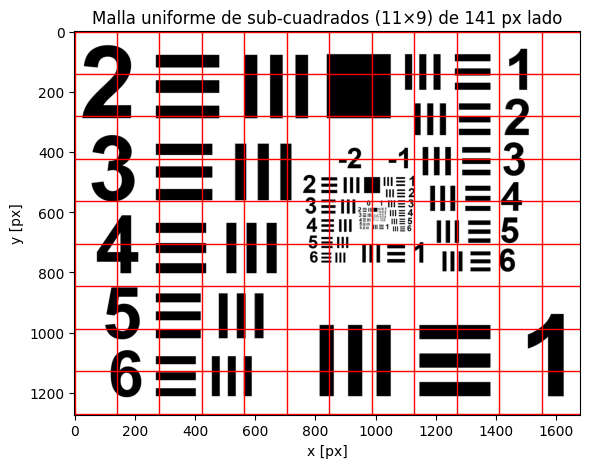

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from Prop_MOD import angular_spectrum_propagation
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


# Parámetros de subdivisión deseados
nx_sub, ny_sub = 11 , 9  # número de sub-cuadrados en x e y

img = cv2.imread('USAF.png', cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se encontró 'USAF.png' en el directorio de trabajo.")
M, N = img.shape 
s_x = N // nx_sub
s_y = M // ny_sub
S = min(s_x, s_y) 
nx_eff = N // S
ny_eff = M // S
x_edges = np.arange(0, (nx_eff+1)*S, S)
y_edges = np.arange(0, (ny_eff+1)*S, S)

# Visualizar la malla sobre la imagen
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray', origin='upper')
for x in x_edges:
    plt.axvline(x, color='r', linewidth=1)
for y in y_edges:
    plt.axhline(y, color='r', linewidth=1)
plt.title(f'Malla uniforme de sub-cuadrados ({nx_eff}×{ny_eff}) de {S} px lado')
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.tight_layout()
plt.show()


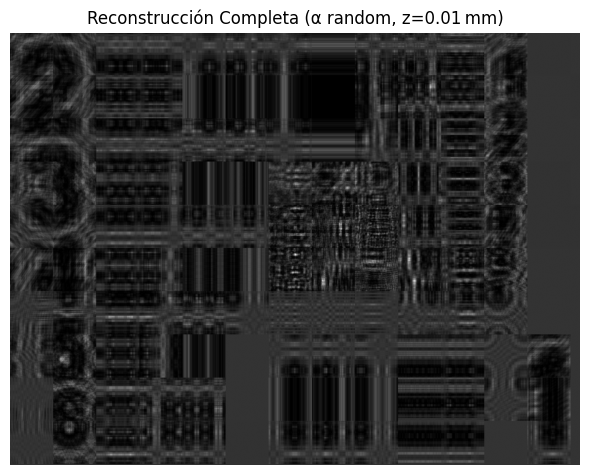

Guardados 154 parches en 'patches/' y reconstrucción completa en 'intensity_full.png'.


In [2]:

def main():
    # --- Parámetros físicos ---
    wavelength = 532e-9    # 532 nm
    dx = dy = 1.85e-6      # 1.85 µm por píxel
    z = 10e-3               # 7 mm

    # --- Leer imagen---
    img = cv2.imread('USAF.png', cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError("No se encontró 'USAF.jpg' en el directorio de trabajo.")
    M, N = img.shape
    amp = img.astype(np.float64) / 255.0
    field = amp.astype(np.complex128)

    # --- Definir subdivisión uniforme en cuadrados ---
    nx_des, ny_des = 10, 10
    s_x = N // nx_des
    s_y = M // ny_des
    S = min(s_x, s_y)
    x_edges = np.concatenate((np.arange(0, N, S), [N]))
    y_edges = np.concatenate((np.arange(0, M, S), [M]))
    nx = len(x_edges) - 1
    ny = len(y_edges) - 1

    # --- Generar mapa de índices de refracción 1.0 a 1.6 ---
    n_map = np.linspace(1.0, 1.6, nx * ny).reshape(ny, nx)

    # --- Parámetros para simular α ---
    alpha_min, alpha_max = 0.1 , 1.0  # rango de α en 1/m

    # STRATEGY: eliger uno de estos 'uniform', 'gradient', 'random'
    strategy = 'random'

    if strategy == 'uniform':
        # α constante en todo el campo
        alpha_map = np.full((ny, nx), (alpha_min + alpha_max) / 2)
    elif strategy == 'gradient':
        # α varía linealmente de izquierda a derecha
        alpha_map = np.tile(
            np.linspace(alpha_min, alpha_max, nx),
            (ny, 1)
        )
    elif strategy == 'random':
        # α aleatorio por parche
        alpha_map = np.random.uniform(alpha_min, alpha_max, size=(ny, nx))
    else:
        raise ValueError(f"Estrategia '{strategy}' no soportada.")

    # --- Preparar carpeta de salida y buffer completo ---
    out_dir = 'patches'
    os.makedirs(out_dir, exist_ok=True)
    output = np.zeros_like(field, dtype=np.complex128)

    # --- Bucle de propagación + absorción + guardado ---
    for i in range(ny):
        for j in range(nx):
            y0, y1 = y_edges[i],   y_edges[i+1]
            x0, x1 = x_edges[j],   x_edges[j+1]
            patch = field[y0:y1, x0:x1]
            n_cell = n_map[i, j]
            alpha = alpha_map[i, j]

            # 1) Propagar parche
            patch_prop = angular_spectrum_propagation(
                patch, wavelength, dx, dy, z, n_cell
            )
            # 2) Aplicar absorción simulada
            patch_prop *= np.exp(-alpha * z)

            # 3) Guardar parche como imagen (intensidad normalizada)
            intensity_patch = np.abs(patch_prop)**2
            norm = cv2.normalize(intensity_patch, None, 0, 255, cv2.NORM_MINMAX)
            img_uint8 = norm.astype(np.uint8)
            fname = f"n{n_cell:.2f}_a{alpha:.2f}.png"
            cv2.imwrite(os.path.join(out_dir, fname), img_uint8)

            # 4) Insertar parche en la reconstrucción completa
            output[y0:y1, x0:x1] = patch_prop

    # --- Mostrar reconstrucción completa ---
    intensity_full = np.abs(output)**2
    plt.figure(figsize=(6, 6))
    plt.imshow(intensity_full, cmap='gray', origin='upper')
    plt.title(f'Reconstrucción Completa (α {strategy}, z={z} mm)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # --- Guardar reconstrucción completa ---
    np.save('intensity_full.npy', intensity_full)
    plt.imsave('intensity_full.png', intensity_full, cmap='gray')

    print(f"Guardados {nx*ny} parches en '{out_dir}/' y reconstrucción completa en 'intensity_full.png'.")

if __name__ == '__main__':
    main()


Recorte completo guardado en 'cropped_patches\Ref_EXT.png' (852×714 px).


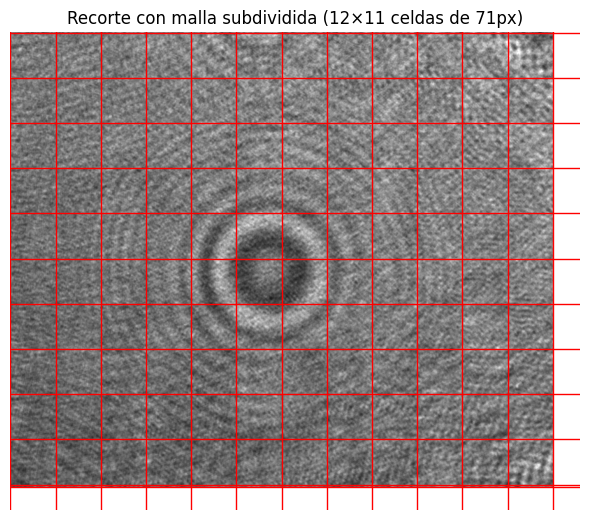

Guardados 132 sub-cuadros en 'cropped_patches\sub_patches/'.


In [3]:

def select_and_save_roi_with_mesh(image_path, out_dir='cropped_patches', nx_sub=10, ny_sub=10):
    # Carga la imagen en escala de grises
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se encontró '{image_path}'")

    # Crear ventana resizable para selección
    cv2.namedWindow("Selecciona región", cv2.WINDOW_NORMAL)
    h, w = img.shape
    cv2.resizeWindow("Selecciona región", min(w,1600), min(h,900))

    # Selección de ROI
    x, y, w_roi, h_roi = cv2.selectROI("Selecciona región", img, showCrosshair=True, fromCenter=False)
    cv2.destroyWindow("Selecciona región")

    if w_roi == 0 or h_roi == 0:
        print("No se seleccionó ninguna región. Saliendo.")
        return

    # Recortar sin cambiar resolución y guardar recorte completo con nombre Ref_EXT.png
    crop = img[y:y+h_roi, x:x+w_roi]
    full_crop_path = os.path.join(out_dir, 'Ref_EXT.png')
    os.makedirs(out_dir, exist_ok=True)
    cv2.imwrite(full_crop_path, crop)
    print(f"Recorte completo guardado en '{full_crop_path}' ({w_roi}×{h_roi} px).")

    # Calcular lado uniforme para sub-cuadrados
    sx = w_roi // nx_sub
    sy = h_roi // ny_sub
    S = min(sx, sy)

    # Crear bordes para la malla, garantizando cubrir todo el recorte
    x_edges = np.concatenate((np.arange(0, w_roi, S), [w_roi]))
    y_edges = np.concatenate((np.arange(0, h_roi, S), [h_roi]))
    nx = len(x_edges) - 1
    ny = len(y_edges) - 1

    # Crear carpeta para sub-cuadros
    sub_dir = os.path.join(out_dir, 'sub_patches')
    os.makedirs(sub_dir, exist_ok=True)

    # Guardar cada sub-cuadro
    for i in range(ny):
        for j in range(nx):
            x0, x1 = x_edges[j], x_edges[j+1]
            y0, y1 = y_edges[i], y_edges[i+1]
            patch = crop[y0:y1, x0:x1]
            patch_name = f'patch_{i}_{j}.png'
            cv2.imwrite(os.path.join(sub_dir, patch_name), patch)

    # Mostrar el recorte con la malla superpuesta para verificación
    plt.figure(figsize=(6, 6))
    plt.imshow(crop, cmap='gray', origin='upper')
    for xe in x_edges:
        plt.axvline(xe, color='r', linewidth=1)
    for ye in y_edges:
        plt.axhline(ye, color='r', linewidth=1)
    plt.title(f"Recorte con malla subdividida ({nx}×{ny} celdas de {S}px)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print(f"Guardados {nx*ny} sub-cuadros en '{sub_dir}/'.")

if __name__ == "__main__":
    select_and_save_roi_with_mesh('Ref.png', out_dir='cropped_patches', nx_sub=10, ny_sub=10)


In [ ]:

PATCHES_DIR = 'patches'
SUBPATCHES_DIR = os.path.join('cropped_patches', 'sub_patches')
OUT_DIR = 'graficas'
os.makedirs(OUT_DIR, exist_ok=True)

# Cargar imágenes de sub_patches
sub_filenames = sorted(os.listdir(SUBPATCHES_DIR))
sub_images = []
for sfname in sub_filenames:
    spath = os.path.join(SUBPATCHES_DIR, sfname)
    simg = cv2.imread(spath, cv2.IMREAD_GRAYSCALE)
    if simg is not None:
        sub_images.append((sfname, simg))

# Iterar sobre cada imagen de patches
patch_filenames = sorted(os.listdir(PATCHES_DIR))
for pidx, pfname in enumerate(patch_filenames):
    ppath = os.path.join(PATCHES_DIR, pfname)
    pimg = cv2.imread(ppath, cv2.IMREAD_GRAYSCALE)
    if pimg is None:
        print(f"No se pudo leer {pfname}, se omite.")
        continue

    psnr_vals = []
    ssim_vals = []
    labels = []

    for sfname, simg in sub_images:
        # Redimensionar sub-imagen si tamaño distinto
        if simg.shape != pimg.shape:
            simg_r = cv2.resize(simg, (pimg.shape[1], pimg.shape[0]), interpolation=cv2.INTER_AREA)
        else:
            simg_r = simg

        # Filtrar imágenes muy pequeñas para SSIM
        if min(simg_r.shape) < 7 or min(pimg.shape) < 7:
            print(f"Ignorando '{sfname}' para '{pfname}' por tamaño menor a 7 px: {simg_r.shape}")
            continue

        val_psnr = psnr(pimg.astype(np.float64), simg_r.astype(np.float64), data_range=255)
        val_ssim, _ = ssim(pimg, simg_r, full=True, data_range=255)

        psnr_vals.append(val_psnr)
        ssim_vals.append(val_ssim)
        labels.append(sfname)

    if len(psnr_vals) == 0:
        print(f"No se calcularon métricas para '{pfname}', ningún parche válido.")
        continue

    x = np.arange(len(labels))

    idx_best_psnr = np.argmax(psnr_vals)
    idx_best_ssim = np.argmax(ssim_vals)

    print(f"Patch '{pfname}': Mejor PSNR = {psnr_vals[idx_best_psnr]:.2f} en '{labels[idx_best_psnr]}'")
    print(f"Patch '{pfname}': Mejor SSIM = {ssim_vals[idx_best_ssim]:.4f} en '{labels[idx_best_ssim]}'")

    # Graficar PSNR sin normalizar
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, psnr_vals, marker='o', linestyle='-', color='tab:blue')
    ax.set_title(f"PSNR: {pfname} vs sub_patches")
    ax.set_ylabel('PSNR [dB]')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=6)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"PSNR_{pfname}.png"))
    plt.close(fig)

    # Graficar SSIM sin normalizar
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x, ssim_vals, marker='s', linestyle='--', color='tab:green')
    ax.set_title(f"SSIM: {pfname} vs sub_patches")
    ax.set_ylabel('SSIM')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=90, fontsize=6)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, f"SSIM_{pfname}.png"))
    plt.close(fig)


Patch 'n1.00_a0.47.png': Mejor PSNR = 14.50 en 'patch_10_0.png'
Patch 'n1.00_a0.47.png': Mejor SSIM = 0.1786 en 'patch_10_9.png'
Patch 'n1.00_a0.67.png': Mejor PSNR = 12.83 en 'patch_9_0.png'
Patch 'n1.00_a0.67.png': Mejor SSIM = 0.1533 en 'patch_4_8.png'
Patch 'n1.00_a0.70.png': Mejor PSNR = 12.83 en 'patch_9_0.png'
Patch 'n1.00_a0.70.png': Mejor SSIM = 0.1533 en 'patch_4_8.png'


Mejor PSNR global: 19.33 con n = 1.000
Mejor SSIM global: 0.3274 con n = 1.000


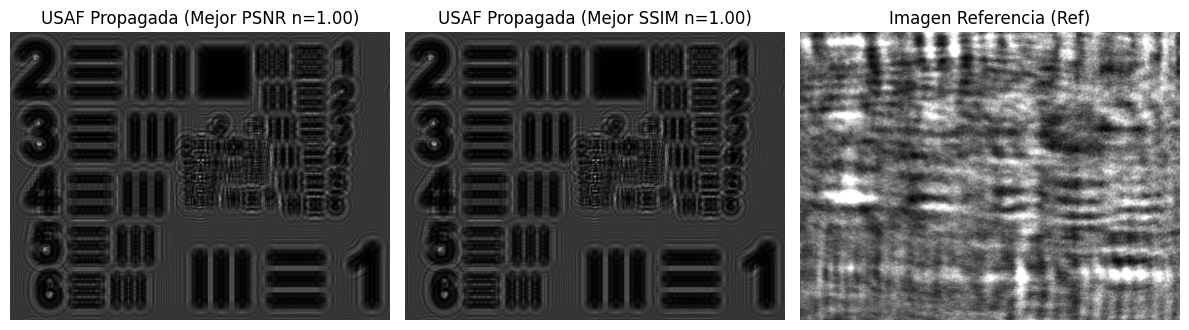

In [ ]:

PATCHES_DIR = 'patches'
SUBPATCHES_DIR = os.path.join('cropped_patches', 'sub_patches')
USAF_PATH = 'USAF.png'    # Imagen completa para propagar
REF_PATH = os.path.join('cropped_patches', 'Ref_EXT.png')
OUT_DIR = 'final_output'
os.makedirs(OUT_DIR, exist_ok=True)

# Cargar imágenes sub_patches
sub_filenames = sorted(os.listdir(SUBPATCHES_DIR))
sub_images = []
sub_ns = []  # guardar n asociados
for sfname in sub_filenames:
    spath = os.path.join(SUBPATCHES_DIR, sfname)
    simg = cv2.imread(spath, cv2.IMREAD_GRAYSCALE)
    if simg is not None:
        try:
            n_str = sfname.split('_')[0]  # 'n1.23'
            n = float(n_str[1:])
        except:
            n = 1.0
        sub_images.append((sfname, simg))
        sub_ns.append(n)

# Parámetros físicos para propagación
wavelength = 532e-9
dx = dy = 1.85e-6
z = 7e-3

best_psnr_val = -np.inf
best_psnr_n = None
best_ssim_val = -np.inf
best_ssim_n = None

patch_filenames = sorted(os.listdir(PATCHES_DIR))
for pfname in patch_filenames:
    ppath = os.path.join(PATCHES_DIR, pfname)
    pimg = cv2.imread(ppath, cv2.IMREAD_GRAYSCALE)
    if pimg is None:
        continue

    for (sfname, simg), n in zip(sub_images, sub_ns):
        if simg.shape != pimg.shape:
            simg_r = cv2.resize(simg, (pimg.shape[1], pimg.shape[0]), interpolation=cv2.INTER_AREA)
        else:
            simg_r = simg

        if min(simg_r.shape) < 7 or min(pimg.shape) < 7:
            continue

        val_psnr = psnr(pimg.astype(np.float64), simg_r.astype(np.float64), data_range=255)
        val_ssim, _ = ssim(pimg, simg_r, full=True, data_range=255)

        if val_psnr > best_psnr_val:
            best_psnr_val = val_psnr
            best_psnr_n = n

        if val_ssim > best_ssim_val:
            best_ssim_val = val_ssim
            best_ssim_n = n

print(f"Mejor PSNR global: {best_psnr_val:.2f} con n = {best_psnr_n:.3f}")
print(f"Mejor SSIM global: {best_ssim_val:.4f} con n = {best_ssim_n:.3f}")

# Cargar USAF completa como campo complejo
usaf_img = cv2.imread(USAF_PATH, cv2.IMREAD_GRAYSCALE)
if usaf_img is None:
    raise FileNotFoundError(f"No se encontró '{USAF_PATH}'")
usaf_amp = usaf_img.astype(np.float64) / 255.0
usaf_field = usaf_amp.astype(np.complex128)

# Propagar con n mejor PSNR
output_psnr = angular_spectrum_propagation(usaf_field, wavelength, dx, dy, z, best_psnr_n)
intensity_psnr = np.abs(output_psnr)**2
intensity_psnr_norm = cv2.normalize(intensity_psnr, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite(os.path.join(OUT_DIR, f'USAF_propagated_bestPSNR_n{best_psnr_n:.2f}.png'), intensity_psnr_norm)

# Propagar con n mejor SSIM
output_ssim = angular_spectrum_propagation(usaf_field, wavelength, dx, dy, z, best_ssim_n)
intensity_ssim = np.abs(output_ssim)**2
intensity_ssim_norm = cv2.normalize(intensity_ssim, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
cv2.imwrite(os.path.join(OUT_DIR, f'USAF_propagated_bestSSIM_n{best_ssim_n:.2f}.png'), intensity_ssim_norm)

# Guardar la imagen de referencia (ajustando tamaño a USAF si es necesario)
ref_img = cv2.imread(REF_PATH, cv2.IMREAD_GRAYSCALE)
if ref_img is None:
    raise FileNotFoundError(f"No se encontró '{REF_PATH}'")

if ref_img.shape != intensity_psnr_norm.shape:
    ref_resized = cv2.resize(ref_img, (intensity_psnr_norm.shape[1], intensity_psnr_norm.shape[0]), interpolation=cv2.INTER_AREA)
else:
    ref_resized = ref_img

cv2.imwrite(os.path.join(OUT_DIR, 'Ref_resized.png'), ref_resized)

# Mostrar ambas imágenes (propagada con mejor PSNR y referencia)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title(f'USAF Propagada (Mejor PSNR n={best_psnr_n:.2f})')
plt.imshow(intensity_psnr_norm, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f'USAF Propagada (Mejor SSIM n={best_ssim_n:.2f})')
plt.imshow(intensity_ssim_norm, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Imagen Referencia (Ref)')
plt.imshow(ref_resized, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
